In [3]:
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import gc

from tqdm import tqdm

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import tensorflow as tf
import keras
import swifter

from keras import Model
from keras.applications.resnet50 import ResNet50
from keras.preprocessing import image
from keras.applications.resnet50 import preprocess_input, decode_predictions
from keras.layers import GlobalMaxPooling2D
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop
from keras.callbacks import ReduceLROnPlateau

from sklearn.metrics.pairwise import pairwise_distances

warnings.filterwarnings('ignore')


# Getting the data 

In [7]:
DATA_PATH = 'E:/'
IMAGE_PATH = DATA_PATH + 'images/'
IMAGE_SIZE = 224
LIMIT_IMAGES = 1000

In [8]:
dfstyles = pd.read_csv(DATA_PATH + 'styles.csv', error_bad_lines=False, warn_bad_lines=False)
dfstyles['image'] = dfstyles['id'].map(lambda x: str(x) + '.jpg')
dfstyles.columns = dfstyles.columns.str.lower()
print(dfstyles.shape)
dfstyles.head()

(44424, 11)


,id,gender,mastercategory,subcategory,articletype,basecolour,season,year,usage,productdisplayname,image
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Turtle Check Men Navy Blue Shirt,15970.jpg
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012.0,Casual,Peter England Men Party Blue Jeans,39386.jpg
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016.0,Casual,Titan Women Silver Watch,59263.jpg
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011.0,Casual,Manchester United Men Solid Black Track Pants,21379.jpg
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012.0,Casual,Puma Men Grey T-shirt,53759.jpg


In [9]:
dfstyles['articletype'].nunique()

143

In [10]:
dfstyles['articletype'].value_counts().head()


Tshirts         7067
Shirts          3217
Casual Shoes    2845
Watches         2542
Sports Shoes    2036
Name: articletype, dtype: int64

In [11]:
dfstyles['cntarticle'] = dfstyles.groupby('articletype')['id'].transform('count')
dfdata = dfstyles[dfstyles['cntarticle'] > 500]
print(dfdata.shape, dfdata['articletype'].nunique())

(34223, 12) 22


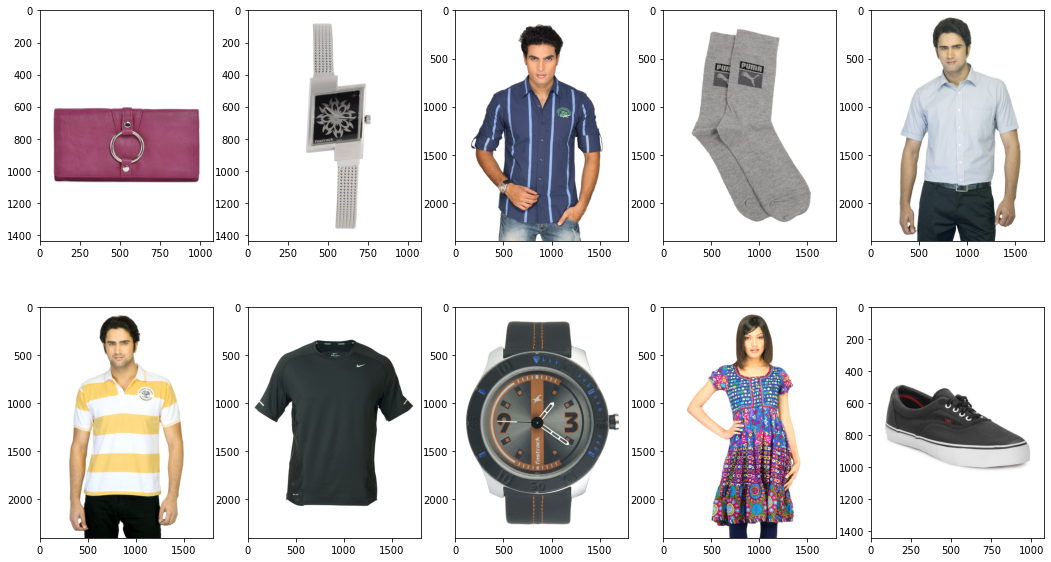

In [10]:
imglist = [IMAGE_PATH + x for x in dfdata['image'].sample(10).values]

fig,ax = plt.subplots(2,5,figsize=(18,10))
for index, img_file in enumerate(imglist):
    img = plt.imread(img_file)
    x = int(index / 5)
    y = index % 5
    ax[x,y].imshow(img)
plt.show() 


# classification


In [12]:
dfarticles =dfdata.groupby('articletype',as_index=False)['id'].count()
dfarticles


,articletype,id
0,Backpacks,724
1,Belts,813
2,Briefs,849
3,Casual Shoes,2845
4,Flip Flops,914
5,Formal Shoes,637
6,Handbags,1759
7,Heels,1323
8,Jeans,609
9,Kurtas,1844


In [12]:
#with tf.device('/GPU:0'):

image_list = []
article_list = []
for index, grouprow in dfarticles.iterrows():
    if index > 4:
        continue
    image_names = dfdata[dfdata['articletype'] == grouprow['articletype']]['image'].values
    if len(image_names) > LIMIT_IMAGES:
        image_names = image_names[:LIMIT_IMAGES]
    image_list.extend(load_images(image_names, grouprow['articletype']))
    article_list.extend(len(image_names) * [grouprow['articletype']])

reading images for Flip Flops: 100%|██████████| 914/914 [00:33<00:00, 27.32it/s]


In [13]:
X = np.array(image_list) / 255.0
X = X.reshape(-1,IMAGE_SIZE,IMAGE_SIZE,3)
y_encoded = LabelEncoder().fit_transform(article_list)
print("Number of classes : ",np.unique(y_encoded, return_counts=True))
y = to_categorical(y_encoded, num_classes = len(np.unique(article_list)))
print(y[:5])

Number of classes :  (array([0, 1, 2, 3, 4], dtype=int64), array([ 724,  813,  849, 1000,  914], dtype=int64))
[[1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]]


In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1)
print(X_train.shape, X_test.shape)

(3870, 224, 224, 3) (430, 224, 224, 3)


In [15]:
#with tf.device('/GPU:0'):

model = Sequential()
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', activation ='relu', input_shape = (224,224,3)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', activation ='relu'))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(len(np.unique(article_list)), activation = "softmax"))
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 32)      2432      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 224, 224, 32)      25632     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 32)      0         
_________________________________________________________________
dropout (Dropout)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 64)      18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 112, 112, 64)      36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 64)        0

In [16]:
del X,y,article_list,image_list
gc.collect()

37

In [21]:
optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
model.compile(optimizer = 'adam' , loss = "categorical_crossentropy", metrics=["accuracy"])
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)
EPOCHS = 3
BATCH_SIZE = 10


#with tf.device('/CPU:0'):

history = model.fit(X_train, y_train, batch_size = BATCH_SIZE, epochs = EPOCHS, validation_data = (X_test, y_test))

In [23]:
datagen = image.ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(X_train)

# Similarity 

In [16]:
dfdata = dfstyles[dfstyles['articletype'] == 'Watches']
dfdata.shape

(2542, 12)

In [17]:
resnet50_model = ResNet50(weights='imagenet', include_top=False, input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
resnet50_model.trainable = False
model2 = keras.Sequential([
    resnet50_model,
    GlobalMaxPooling2D()
])

model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_max_pooling2d_1 (Glob (None, 2048)              0         
Total params: 23,587,712
Trainable params: 0
Non-trainable params: 23,587,712
_________________________________________________________________


In [18]:
def get_embedding(model, imagepath):
    x = image.load_img(imagepath, target_size=(IMAGE_SIZE, IMAGE_SIZE))
    x = image.img_to_array(x)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return model.predict(x).reshape(-1)

image_file = IMAGE_PATH + dfdata.iloc[0]['image']
emb = get_embedding(model2, image_file)
emb.shape

(2048,)

In [19]:
map_embedding = dfdata['image'].swifter.apply(lambda x : get_embedding(model2, IMAGE_PATH + x))


In [20]:
dfembedding = map_embedding.apply(pd.Series)
dfembedding.shape

(2542, 2048)

In [21]:
cosine_similarity = 1 - pairwise_distances(dfembedding,metric='cosine')


In [148]:
indices = pd.Series(range(len(dfdata)), index=dfdata.index)
indices.head(20)

2       0
9       1
16      2
20      3
38      4
42      5
50      6
58      7
62      8
86      9
104    10
125    11
130    12
149    13
156    14
158    15
164    16
165    17
168    18
192    19
dtype: int64

In [168]:
sim_index = 20
sim_indices,sim = get_recommender(sim_index, dfdata, top_n = 5)
sim_indices

Int64Index([27649, 24121, 11156, 37992, 7493], dtype='int64')

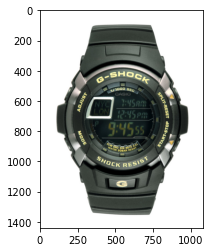

In [169]:
selected_image = IMAGE_PATH + dfdata.loc[sim_index,'image']
img = plt.imread(selected_image)
plt.imshow(img)
plt.show()

In [163]:
width=5
height=5
rows = 1
cols = 5
axes=[]

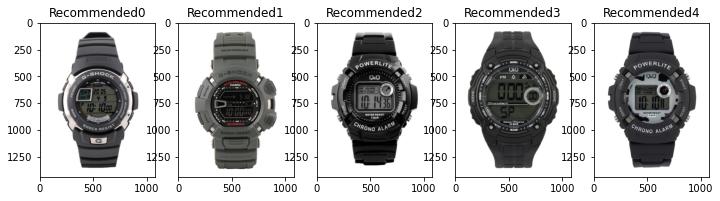

In [170]:
fig=plt.figure(figsize=(12,12))
similar_list = [IMAGE_PATH + x for x in dfdata.loc[sim_indices,'image']]
for a in range(rows*cols):
    try:
        img = plt.imread(similar_list[a])
    except IndexError:
        break
    axes.append( fig.add_subplot(rows, cols, a+1) )
    subplot_title=("Recommended"+str(a))
    axes[-1].set_title(subplot_title)  
    plt.imshow(img)
plt.show()